# Importing Packages

In [1]:
"""
Importing (using/include) packages and files needed for the code to run

Note: that we import pyplot last to avoid a name conflict with grid
"""

using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using DataFrames
using PyCall
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Model Topography Setup

In [2]:
function initial_ice_depth(x::Float64)
    """
    Arguments:
    x::Float64 -- A horizontal value of float64

    Returns:
    The vertical value (depth) corresponding to the horizontal argument value

    Info:
    The initial topography setup follows the following.
    y = A*sin[k(x-b)]+c
    |A| is the amplitude
    k is the wave number (k=2π/wavelength)
    The period is 2π/k
    The horizontal shift is b
    The vertical shift is c
    """
    w = 90000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
    """
    Arguments:
    x::Float64 -- A horizontal value of float64

    Returns:
    The vertical value (depth) corresponding to the horizontal argument value
    """
     return 1e4
end

function ice_viscosity(T::Float64)
    """
    Arguments:
    T::Float64 --- A temperature value in (Kelvin) of float64

    Returns:
    ice_vis -- The ice viscosity in (Pa*s) that is dependent on temperature argument value

    Info:
    The equation used is a Newtonian formulation for temperature-dependent ice viscosity from Nimmo(2004)
    """
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else
        ice_vis = ice_vis
    end
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    """
    Building composite types with a list of fields (or attributes) which are names that will be used as variables to store data for
    objects of the new types.

    Fields:
    alpha::Vector{Float64} -- A vector(1-D Array) that holds values of Thermal expansion in (1/K)
    rho0::Vector{Float64} -- A vector (1-D Array) that holds values of  Density in (kg/m^3)
    Hr::Vector{Float64} -- A vector(1-D Array) that holds values of Radiogenic heat production in (W/m^3)
    Cp::Vector{Float64} -- A vector(1-D Array) that holds values of Heat capacity in (J/kg*K)
    kThermal::Vector{Float64} -- A vector(1-D Array) that holds values of Thermal conductivity in (W/m*K)
    eta::Vector{Float64} -- A vector(1-D Array) that holds values of Viscosity in (Pa*s)

    Info:
    Each vector hold 3 elements which correspond to layer
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    """
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3
            markers.scalars[T,i] = 100.0
        end
    end
end

# function update_marker_viscosity!(markers::Markers,materials::Materials)
#     eta = markers.scalarFields["eta"]
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     for i in 1:markers.nmark
#         if mmat[i] == 2
#             markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
#         end
#     end
# end


# function update_marker_density!(markers::Markers,materials::Materials)
#     rho = markers.scalarFields["rho"]
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     for i in 1:markers.nmark
#         markers.scalars[rho,i] = materials.rho0[mmat[i]]
#     end
# end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # Viscosity is being assigned by the function ice_viscosity and being updated by the function update_markers_prop!
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end
    update_marker_prop!(markers,materials)
end

function get_i_interface(grid::CartesianGrid,mat,contour_value)
    # Setting up inital model schematic
    i_interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if i_mat[i,j] == contour_value
                i_interface_position[j] = grid.yc[j]
                break
            elseif i_mat[i+1,j] < contour_value
                # interface is located within this cell.
                i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                break
            end
            i = i+1
        end
    end
    return i_interface_position
end

function get_interface(grid::CartesianGrid,mat,contour_value)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
        i = 1
            while i <= grid.ny
                if mat[i,j] == contour_value
                    interface_position[j] = grid.yc[i]
                    break
                elseif mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                    break
                end
                i = i+1
            end
        end
    return interface_position
end

# function update_interface_temp!(markers::Markers,materials::Materials)
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     ocean_ice_interface = get_interface(grid,mat,1.5)
#     air_ice_interface = get_interface(grid,mat,2.5)
#     for i in 1:markers.nmark
#         if mmat[i] ==
#         markers.scalars[T,i] = 273.0
#         elseif mmat[i] == air_ice_interface
#         markers.scalars[T,i] = 100.0
#         end
#     end
# end

get_interface (generic function with 1 method)

# Model Setup

Creating Markers...
  0.150384 seconds (153.94 k allocations: 81.967 MiB, 6.79% gc time, 79.80% compilation time)
Initial condition...
  0.260460 seconds (3.50 M allocations: 57.424 MiB, 4.28% gc time, 27.59% compilation time: 25% of which was recompilation)
assigning left boundary temperature 273.0
Trying with timestep 0.16203257402125654 kyr
assigning left boundary temperature 273.0
dTmax=2.2466711302448488 dt=0.16203257402125654 kyr
Writing visualization file = test/viz.0000.vtr
Writing visualization file = test/markers.0000.vtp
  0.006180 seconds (2 allocations: 10.986 MiB)
Finished Step 2 time=0.16203257402125654 kyr


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


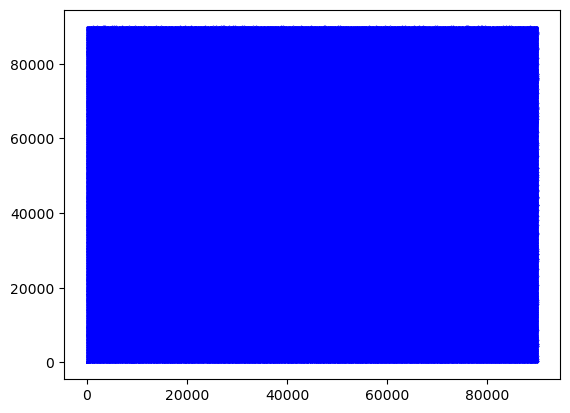

In [4]:
# nstep=10
nx = 101
ny = 201
W = 90000.0
H = 90000.0
gx = 0.0
gy = 0.113

# Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbctype = [1,-1,1,1]
# Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
Tbcval = [273.0,0.0,100.0,273.0]
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
materials = Materials()

markx = 6
marky = 6
seconds_in_year = 3.15e7
plot_interval = 1e6*seconds_in_year # plot interval in seconds
end_time = 3e7*seconds_in_year
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
println("Initial condition...")
@time initial_conditions!(markers, materials)

time_plot = []
max_topo = []
### Setting up agruments for interface function ###
# initial
i_air_ice_interface = zeros(Float64,grid.nx+1)
i_ocean_ice_interface = zeros(Float64,grid.nx+1)
i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)

# after
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")


### Setting up agruments for termination criteria ###
max_step::Int64=0
max_time::Float64=-1.0
max_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step

# # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
# kThermal = 3.0 .*ones(grid.ny,grid.nx);

time = 0.0
iout= 0
last_plot = 0.0
dt = 1e10

rho_c = nothing
rho_vx = nothing
rho_vy = nothing
alpha = nothing
Hr = nothing
Cp_c = nothing
eta_s = nothing
eta_n = nothing
vxc = nothing
vyc = nothing
T = nothing
dTmax = nothing
dTemp = nothing
Tnew = nothing
Tlast = nothing
x_time = nothing
kThermal = nothing

itime = 1
output_dir = "test"

terminate = false
while !terminate
    # 0. update the markers properties
    update_marker_prop!(markers,materials)
    update_marker_temp!(markers,materials)
#    update_interface_temp!(markers,materials)
    # 1. Transfer properties markers -> nodes
    # 1a. Basic Nodes
    eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
    # 1b. Cell Centers
    rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
    # 1c. Vx and Vy nodes:
    rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
    rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")

    # deal with any NaN values from interpolation:
    if itime > 1
        if any(isnan.(eta_s_new))
            println("found nan values")
        end
        replace_nan!(eta_s,eta_s_new)
        replace_nan!(rho_c,rho_c_new)
        replace_nan!(Hr,Hr_new)
        replace_nan!(Cp_c,Cp_c_new)
        replace_nan!(alpha,alpha_new)
        replace_nan!(eta_n,eta_n_new)
        replace_nan!(Tlast,Tlast_new)
        replace_nan!(rho_vx,rho_vx_new)
        replace_nan!(rho_vy,rho_vy_new)
        replace_nan!(kThermal,kThermal_new)
    end
    # Copy field data
    kThermal = copy(kThermal_new)
    rho_vx = copy(rho_vx_new)
    rho_vy = copy(rho_vy_new)
    rho_c = copy(rho_c_new)
    Hr = copy(Hr_new)
    Cp_c = copy(Cp_c_new)
    alpha = copy(alpha_new)
    eta_s = copy(eta_s_new)
    eta_n = copy(eta_n_new)
    Tlast = copy(Tlast_new)

    if itime == 1
        ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:])
    else
        ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
    end

    # 2. Assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
    stokes_solution = L\R
    vx,vy,P = unpack(stokes_solution,grid;ghost=true)

    # Get the velocity at the cell centers:
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
    shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
    H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

    # 3. Compute the advection timestep
    if itime > 1
        this_dtmax = min(1.2*dt,dtmax)
    else
        this_dtmax = dtmax
    end
    dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
    diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
    if dt > diffusion_timestep
        dt = diffusion_timestep
    end

    dTmax = Inf
    dTemp = nothing
    Tnew = nothing
    titer = 1
    for titer=1:2
        # assemble and solve the energy equation
#         println("Trying with timestep ",dt/3.15e7/1e6," Myr")
        println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
#         println("Trying with timestep ",dt/seconds_in_year," yr")
#         println("Trying with timestep ",dt," Seconds")
        L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
        Tnew = L\R;
        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
        T = copy(Tnew)

        dTemp = Tnew-Tlast
        # compute the maximum temperature change
        dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
#         println("dTmax=",dTmax," dt=",dt/3.15e7/1e6," Myr")
        println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
#         println("dTmax=",dTmax," dt=",dt/seconds_in_year," Seconds")
        dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
        if dTmax < 10.0
            break
        end
    end

    dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
    #dT_remaining = dTemp - dT_subgrid_node
    Tnew = Tnew .- dT_subgrid_node

    cell_center_change_to_markers!(markers,grid,Tnew,"T")

    # Checking Termination Criteria, time is in Myr
    if time >= max_time || itime >= max_step
        terminate = true
    end

#     if time == 0.0 || time - last_plot >= plot_interval  || mod(itime,100) == 0
#         last_plot = time
#         name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#         vn = velocity_to_basic_nodes(grid,vxc,vyc)
#         visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
#         name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#         visualization(markers,time/seconds_in_year;filename=name)
#         iout += 1
#     end

    if time == 0.0 || mod(itime,100) == 0 || true
        last_plot = time
        # Gird output
        name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
        println("Writing visualization file = ",name1)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)
        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
        # Markers output
        name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name2)
        visualization(markers,time/seconds_in_year;filename=name2)
        iout += 1
    end

    # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
    # Moving the markers and advancing to the next timestep
    move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
    time += dt
    itime += 1
    # println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
#     println("Finished Step ",itime," time=",time/seconds_in_year," yr")
#     println("Finished Step ",itime," time=",time," Seconds")
    x_time = @sprintf("%.3g",time/3.15e7/1e6);
    mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    ocean_ice_interface = get_interface(grid,mat,1.5)
    air_ice_interface = get_interface(grid,mat,2.5)
    append!(time_plot,time)
    append!(max_topo,maximum(ocean_ice_interface.-(0.5*90000.0)))
end

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

# Numerical and Analytic Hydrostatic Pressure Functions

In [195]:
function numerical_hydrostatic_pressure(grid::CartesianGrid,rho_vy::Matrix{Float64},gy::Float64)
    """
    Arguments:
    rho_vy -- the density on the y-velocity node in(kg/^3)
    gy -- the acceleration due to gravity in the y-direction in (m/s^2)
    
    Returns: 
    hydro_press -- the hydostatic pressure in (MPa)
    """
    
    hydro_press = zeros(Float64,(grid.ny+1,grid.nx))    
    
    for j in 1:grid.nx
        for i in 1:grid.ny+1
            if i == 1
                hydro_press[i,j] = gy*rho_vy[1,j]*abs(grid.yc[i])
            else
                hydro_press[i,j] = hydro_press[i-1,j] + gy*rho_vy[i-1,j]*(grid.yc[i]-grid.yc[i-1])
            end
        end 
    end 
    return hydro_press/(1e+6)
end

function analytic_hydrostatic_pressure(grid::CartesianGrid,density::Array,gy::Float64)
    """
    Arguments:
    depth -- the depth in (m)
    density -- the density of the fluid in (kg/^3)
    gravity -- the acceleration due to gravity in (m/s^2)
    
    Returns: 
    pressure -- the hydostatic pressure in (MPa)
    """
    
    pressure = zeros(Float64,grid.ny+1)
    hice = initial_ice_depth(1.0)
    hsurf = initial_surface_depth(1.0)

    for i in 1:grid.ny+1
        if grid.yc[i] < hsurf
            pressure[i] = density[1]*gy*abs(grid.yc[i])
        elseif hsurf < grid.yc[i] < hice
            Pair = density[1]*gy*hsurf
            pressure[i] = Pair + density[2]*gy*(grid.yc[i]-hsurf)
        else
            Pair = density[1]*gy*hsurf
            Pice = density[2]*gy*(hice-hsurf)
            pressure[i] = Pair + Pice + density[3]*gy*(grid.yc[i]-hice)
        end
    end
    return pressure/(1e+6)
end

analytic_hydrostatic_pressure (generic function with 1 method)

# Printing Numerical Calculations

In [196]:
depth = grid.yc/1000
hydrostatic_pressure = numerical_hydrostatic_pressure(grid,rho_vy,gy)
hydrostatic_pressure = hydrostatic_pressure[:,1]
for (depth,hydrostatic_pressure) in zip(depth,hydrostatic_pressure)
    println("The hydrostatic pressure at a depth of $(round(depth,digits=2))(km) is $(round(hydrostatic_pressure,digits=6))(MPa)")
end

The hydrostatic pressure at a depth of -0.22(km) is 2.5e-5(MPa)
The hydrostatic pressure at a depth of 0.22(km) is 7.6e-5(MPa)
The hydrostatic pressure at a depth of 0.68(km) is 0.000127(MPa)
The hydrostatic pressure at a depth of 1.12(km) is 0.000178(MPa)
The hydrostatic pressure at a depth of 1.58(km) is 0.000229(MPa)
The hydrostatic pressure at a depth of 2.02(km) is 0.00028(MPa)
The hydrostatic pressure at a depth of 2.48(km) is 0.000331(MPa)
The hydrostatic pressure at a depth of 2.92(km) is 0.000381(MPa)
The hydrostatic pressure at a depth of 3.38(km) is 0.000432(MPa)
The hydrostatic pressure at a depth of 3.82(km) is 0.000483(MPa)
The hydrostatic pressure at a depth of 4.28(km) is 0.000534(MPa)
The hydrostatic pressure at a depth of 4.72(km) is 0.000585(MPa)
The hydrostatic pressure at a depth of 5.18(km) is 0.000636(MPa)
The hydrostatic pressure at a depth of 5.62(km) is 0.000686(MPa)
The hydrostatic pressure at a depth of 6.08(km) is 0.000737(MPa)
The hydrostatic pressure at a

The hydrostatic pressure at a depth of 69.97(km) is 6.461214(MPa)
The hydrostatic pressure at a depth of 70.42(km) is 6.512064(MPa)
The hydrostatic pressure at a depth of 70.88(km) is 6.562914(MPa)
The hydrostatic pressure at a depth of 71.32(km) is 6.613764(MPa)
The hydrostatic pressure at a depth of 71.78(km) is 6.664614(MPa)
The hydrostatic pressure at a depth of 72.22(km) is 6.715464(MPa)
The hydrostatic pressure at a depth of 72.68(km) is 6.766314(MPa)
The hydrostatic pressure at a depth of 73.12(km) is 6.817164(MPa)
The hydrostatic pressure at a depth of 73.57(km) is 6.868014(MPa)
The hydrostatic pressure at a depth of 74.03(km) is 6.918864(MPa)
The hydrostatic pressure at a depth of 74.47(km) is 6.969714(MPa)
The hydrostatic pressure at a depth of 74.92(km) is 7.020564(MPa)
The hydrostatic pressure at a depth of 75.38(km) is 7.071414(MPa)
The hydrostatic pressure at a depth of 75.82(km) is 7.122264(MPa)
The hydrostatic pressure at a depth of 76.28(km) is 7.173114(MPa)
The hydros

# Printing Analytic Solutions

In [197]:
density = [1.0,920.0,1000.0]
pressure = analytic_hydrostatic_pressure(grid,density,gy)
for (depth,pressure) in zip(depth,pressure)
    println("The hydrostatic pressure at a depth of $(round(depth,digits=2))(km) is $(round(pressure,digits=6))(MPa)")
end

The hydrostatic pressure at a depth of -0.22(km) is 2.5e-5(MPa)
The hydrostatic pressure at a depth of 0.22(km) is 2.5e-5(MPa)
The hydrostatic pressure at a depth of 0.68(km) is 7.6e-5(MPa)
The hydrostatic pressure at a depth of 1.12(km) is 0.000127(MPa)
The hydrostatic pressure at a depth of 1.58(km) is 0.000178(MPa)
The hydrostatic pressure at a depth of 2.02(km) is 0.000229(MPa)
The hydrostatic pressure at a depth of 2.48(km) is 0.00028(MPa)
The hydrostatic pressure at a depth of 2.92(km) is 0.000331(MPa)
The hydrostatic pressure at a depth of 3.38(km) is 0.000381(MPa)
The hydrostatic pressure at a depth of 3.82(km) is 0.000432(MPa)
The hydrostatic pressure at a depth of 4.28(km) is 0.000483(MPa)
The hydrostatic pressure at a depth of 4.72(km) is 0.000534(MPa)
The hydrostatic pressure at a depth of 5.18(km) is 0.000585(MPa)
The hydrostatic pressure at a depth of 5.62(km) is 0.000636(MPa)
The hydrostatic pressure at a depth of 6.08(km) is 0.000686(MPa)
The hydrostatic pressure at a d

The hydrostatic pressure at a depth of 69.97(km) is 6.461899(MPa)
The hydrostatic pressure at a depth of 70.42(km) is 6.512749(MPa)
The hydrostatic pressure at a depth of 70.88(km) is 6.563599(MPa)
The hydrostatic pressure at a depth of 71.32(km) is 6.614449(MPa)
The hydrostatic pressure at a depth of 71.78(km) is 6.665299(MPa)
The hydrostatic pressure at a depth of 72.22(km) is 6.716149(MPa)
The hydrostatic pressure at a depth of 72.68(km) is 6.766999(MPa)
The hydrostatic pressure at a depth of 73.12(km) is 6.817849(MPa)
The hydrostatic pressure at a depth of 73.57(km) is 6.868699(MPa)
The hydrostatic pressure at a depth of 74.03(km) is 6.919549(MPa)
The hydrostatic pressure at a depth of 74.47(km) is 6.970399(MPa)
The hydrostatic pressure at a depth of 74.92(km) is 7.021249(MPa)
The hydrostatic pressure at a depth of 75.38(km) is 7.072099(MPa)
The hydrostatic pressure at a depth of 75.82(km) is 7.122949(MPa)
The hydrostatic pressure at a depth of 76.28(km) is 7.173799(MPa)
The hydros

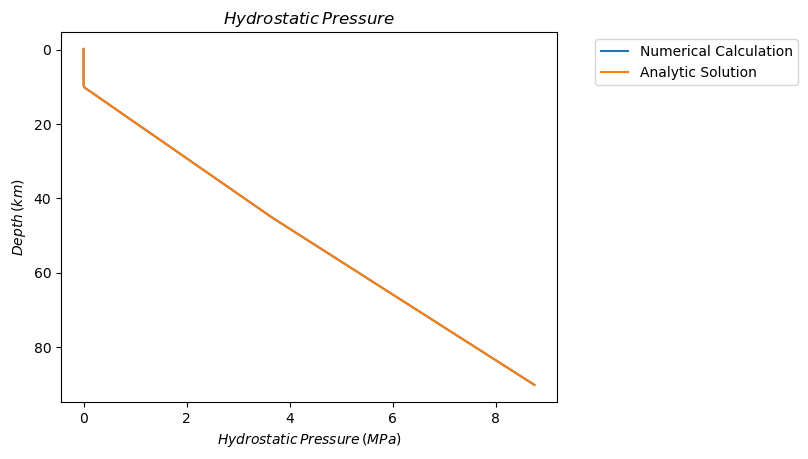

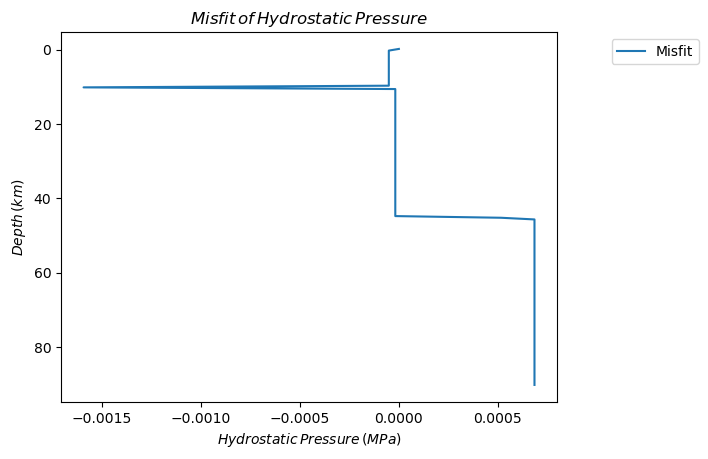

In [198]:
figure()
title(L"Hydrostatic\,Pressure")
plot(hydrostatic_pressure[:,1],grid.yc/1000,label="Numerical Calculation")
plot(pressure,depth,label="Analytic Solution")
gca().invert_yaxis()
gca().set_ylabel(L"Depth\,(km)")
gca().set_xlabel(L"Hydrostatic\,Pressure\,(MPa)")
legend(loc="upper right",bbox_to_anchor=[1.5,1.0])
show()

figure()
title(L"Misfit\,of\,Hydrostatic\,Pressure")
plot(pressure-hydrostatic_pressure[:,1],grid.yc/1000,label="Misfit")
gca().invert_yaxis()
gca().set_ylabel(L"Depth\,(km)")
gca().set_xlabel(L"Hydrostatic\,Pressure\,(MPa)")
legend(loc="upper right",bbox_to_anchor=[1.3,1.0])
show()